In [1]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# grhpviz
from sklearn.tree import export_graphviz

import graphviz


# 기계 학습 모델 필요 모듈
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier 

from sklearn.model_selection import GridSearchCV

# 모델 성능 평가
from sklearn.metrics import confusion_matrix

# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 구성

In [2]:
df_raw = pd.read_csv("Data/HMEQ.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


In [3]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [4]:
## 범주형 변수
df_raw["JOB"].fillna("Other", inplace=True)

## 연속형 변수
# 결측치 있는 모든 열을 평균으로 대체
df_raw.fillna(df_raw.mean(), inplace =True)

In [5]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### 더미변수 생성

In [6]:
# REASON과 JOB데이터의 더미변수 생성

df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [7]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace = False)

### 데이터 분할

In [8]:
# train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (2623, 18)
train data Y size: (2623,)
test data X size: (1125, 18)
test data Y size: (1125,)


# 2. 모델 생성

In [9]:
nn_uncustomized = MLPClassifier(random_state=1234)
nn_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(nn_uncustomized.score(df_train_x, df_train_y)))

#test데이터 정확
print("Accuracy on test set: {:.3f}".format(nn_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.722
Accuracy on test set: 0.683


- 정확도가 형편 없는 모습을 보여준다. train/test 데이터 모두에 대해 과속적합

### 스케일링

In [10]:
v_feature_name = df_train_x.columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [11]:
### 스케일링 데이터 분할
df_scaled_train_x, df_scaled_test_x= train_test_split(df_scaled, test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_scaled_train_x.shape))
print("test data X size: {}".format(df_scaled_test_x.shape))


train data X size: (2623, 18)
test data X size: (1125, 18)


### 스케일링 데이터로 모델 생성

In [13]:
nn_scaled = MLPClassifier(random_state=1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(nn_scaled.score(df_scaled_train_x, df_train_y)))

#test데이터 정확도
print("Accuracy on test set: {:.3f}".format(nn_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set: 0.971
Accuracy on test set: 0.943


/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


- 데이터를 스케일링한 것만으로 성능이 매우 좋아졌음을 확인할 수 있다.

## 하이퍼 파라미터 변경

### HiddenLayer: 은닉층 변경
- NN모델은 트레이닝에 꽤나오랜 시간이 걸린다.

In [13]:
train_accuracy=[]; test_accuracy = []

para_hidden = [20*hidden for hidden in range(1, 11)] 

for v_hidden in para_hidden:
    nn = MLPClassifier(random_state=1234, hidden_layer_sizes = (v_hidden, v_hidden))
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["Hidden_layer"] = para_hidden

df_accuracy_hidden["TrainScore"] = train_accuracy
df_accuracy_hidden["TestScore"] = test_accuracy

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages

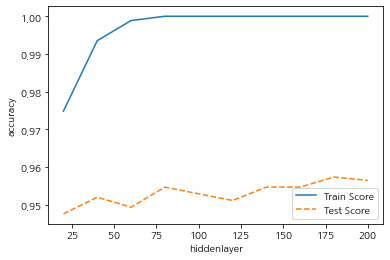

In [14]:
plt.plot(para_hidden, train_accuracy, linestyle="-", label = "Train Score")
plt.plot(para_hidden, test_accuracy, linestyle="--", label = "Test Score")
plt.xlabel("hiddenlayer")
plt.ylabel("accuracy")
plt.legend()

In [15]:
df_accuracy_hidden.round(3)

,Hidden_layer,TrainScore,TestScore
0,20,0.975,0.948
1,40,0.994,0.952
2,60,0.999,0.949
3,80,1.000,0.955
4,100,1.000,0.953
5,120,1.000,0.951
6,140,1.000,0.955
7,160,1.000,0.955
8,180,1.000,0.957
9,200,1.000,0.956


- hidden layer는 40으로 지정
- train/test 데이터 간 격차가 제일 적어 보이는 값으로 선정

### Activation: 활성화함수 변경

In [16]:
train_accuracy=[]; test_accuracy = []

para_function = ["logistic", "tanh", "relu"] 
for v_function in para_function:
    nn = MLPClassifier(random_state=1234, hidden_layer_sizes =(40, 40), activation = v_function)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_function = pd.DataFrame()
df_accuracy_function["Activation"] = para_function
df_accuracy_function["TrainScore"] = train_accuracy
df_accuracy_function["TestScore"] = test_accuracy

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


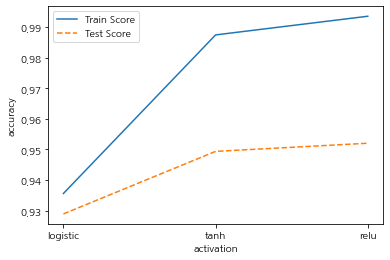

In [17]:
plt.plot(para_function, train_accuracy, linestyle="-", label = "Train Score")
plt.plot(para_function, test_accuracy, linestyle="--", label = "Test Score")
plt.xlabel("activation")
plt.ylabel("accuracy")
plt.legend()

In [18]:
df_accuracy_function.round(3)

,Activation,TrainScore,TestScore
0,logistic,0.936,0.929
1,tanh,0.987,0.949
2,relu,0.994,0.952


- relu함수의 성능이 가장 좋다.

### Solver: 가중치 최적화 변경

In [26]:
train_accuracy=[]; test_accuracy = []

para_solver = ["lbfgs", "sgd", "adam"] 
for v_solver in para_solver:
    nn = MLPClassifier(random_state=1234, hidden_layer_sizes =(40, 40), activation = "relu", solver=v_solver)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainScore"] = train_accuracy
df_accuracy_solver["TestScore"] = test_accuracy

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


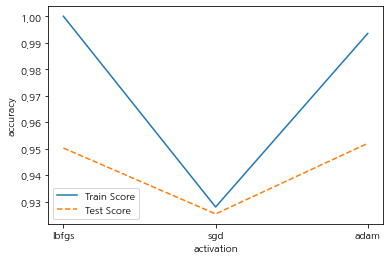

In [27]:
plt.plot(para_solver, train_accuracy, linestyle="-", label = "Train Score")
plt.plot(para_solver, test_accuracy, linestyle="--", label = "Test Score")
plt.xlabel("solver")
plt.ylabel("accuracy")
plt.legend()

In [28]:
df_accuracy_solver.round(3)

,Activation,TrainScore,TestScore
0,lbfgs,1.000,0.950
1,sgd,0.928,0.925
2,adam,0.994,0.952


- solver는 adam으로 선정

### MiniBatch 변경

In [35]:
train_accuracy=[]; test_accuracy = []

para_batch = [20*batch for batch in range(1, 10)] 
for v_minibatch in para_batch:
    nn = MLPClassifier(random_state=1234, hidden_layer_sizes =(40, 40), activation = "relu", solver="adam",
                       batch_size = v_minibatch)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))
    
# 결과 저장
df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Batch"] = para_batch
df_accuracy_batch["TrainScore"] = train_accuracy
df_accuracy_batch["TestScore"] = test_accuracy

/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/piai/anaconda3/lib/python3.8/site-packages

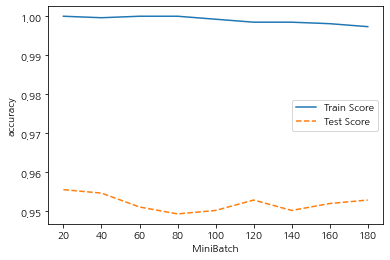

In [36]:
plt.plot(para_batch, train_accuracy, linestyle="-", label = "Train Score")
plt.plot(para_batch, test_accuracy, linestyle="--", label = "Test Score")
plt.xlabel("MiniBatch")
plt.ylabel("accuracy")
plt.legend()

In [37]:
df_accuracy_batch.round(3)

,Batch,TrainScore,TestScore
0,20,1.000,0.956
1,40,1.000,0.955
2,60,1.000,0.951
3,80,1.000,0.949
4,100,0.999,0.950
5,120,0.998,0.953
6,140,0.998,0.950
7,160,0.998,0.952
8,180,0.997,0.953


- batchsize는 train 데이터에는 과적합 경향, test데이터는 미니배치 크기가 증가할수록 오차 증가 경향성 있음
- 배치 사이즈느 120 선정

## 결론 도출

In [46]:
### 최종 모델 선정

In [14]:
nn_final = MLPClassifier(random_state=1234, hidden_layer_sizes =(40, 40), activation = "relu", solver="adam",
                       batch_size = 120)
nn_final.fit(df_scaled_train_x, df_train_y)

y_pred = nn_final.predict(df_scaled_test_x)

# Train 데이터 설명력
print("Accuracy on training set: {:.3f}".format(nn_final.score(df_scaled_train_x, df_train_y)))
#test데이터 설명력
print("Accuracy on test set: {:.3f}".format(nn_final.score(df_scaled_test_x, df_test_y)))
# Confusion Matrix
print("Comfusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))


Accuracy on training set: 0.998
Accuracy on test set: 0.953
Comfusion Matrix: 
[[1017    4]
 [  49   55]]


/home/piai/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


스케일링만 실시한 모델
- Accuracy on training set: 0.944
- Accuracy on test set: 0.935  


초기 모델과 비교해서 정확도가 상승하는 모습을 보이지만, 트레이닝 데이터가 어느정도 과적합되는 현상을 보여준다.

### 추가로 그리드 서치 가능